In [1]:
import line_profiler
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
import track_reconstruction as tr
from track import Track
from hit import Hit


In [30]:
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/10h/data_0000.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing

hits_tree = 'board_57'
evt_tree = 'event'
# br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp']#, 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value', 'timestamp_cal_chi2', 'timestamp_cal_dof', 'value_cal_chi2', 'value_cal_dof', 'value_saturation']
br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp', 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value']
br_list_evt = ['timestamp', 'evt_number', 'flags']
with uproot.open(file_path) as tree:
    hits_dict = tree[hits_tree].arrays(br_list_data, library="np")
    evts_dict = tree[evt_tree].arrays(br_list_evt, library="np")
    
# df_hits = pd.DataFrame.from_dict(hits_dict).query('n_hits > 3')
df_hits = pd.DataFrame.from_dict(hits_dict)
df_evts = pd.DataFrame.from_dict(evts_dict)


KeyInFileError: not found: 'timestamp_event'
in file /Users/lucahartman/Documents/EPFL/MA1/project/10h/data_0000.root
in object /board_57;1

In [3]:
df_hits['timestamp_global'] = df_evts['timestamp']
df_hits.query('n_hits > 2', inplace=True)

In [4]:
def dr(hit_ref, hits):
    ## eval array of vectors connecting all hits with ref hit
    dr = hits - hit_ref

    # dr_u =  np.abs(dr[:,1])
    # dr_d =  np.abs(dr[:,0])
    ## projections
    dr_u =  dr[:,1]
    dr_d =  dr[:,0]
    ## eval module
    dr_mod =  np.sqrt(dr_u*dr_u + dr_d*dr_d)
    return dr_mod

In [28]:
## This function provide the parameters x0 (or y0 depending on which hits we provide) and tx the angle of the trac
def create_tracks(df, plot = False):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    dts_x = []
    dts_y = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hitsX = [Hit(row, i) for i in range(row['n_hits']) if tr.is_sidex(row['tofpet_id'][i])]
        hitsY = [Hit(row, i) for i in range(row['n_hits']) if not tr.is_sidex(row['tofpet_id'][i])]
        index_x = [i for i in range(len(channels)) if tr.is_sidex(tofpet_id[i])]  # index we need for the time calibration
        index_y = [i for i in range(len(channels)) if not tr.is_sidex(tofpet_id[i])]# index we need for the time calibration
        
        ## Some events don't have hits on one of the two sides and are thus not considered
        if len(hitsX)>1 and len(hitsY)>1:
            # get track parameters
            # x0, tx, hits_index_x = tracks2([hit.coord for hit in hitsX], plot)
            # y0, ty, hits_index_y = tracks2([hit.coord for hit in hitsY], plot)
            # create Track objects
            # track_x = Track(hitsX, x0, tx, hits_index_x)
            # track_y = Track(hitsY, y0, ty, hits_index_y)
            track_x = Track(hitsX)
            track_y = Track(hitsY)

            ## check if track has a "good" chi2 value
            if track_x.is_good_fit() and track_y.is_good_fit():
                # worth making a precise track
                track_x.precise_track()
                track_y.precise_track()
                ## calculate the mean time of the track
                track_2D_timestamps = np.concatenate([track_x.get_timestamps(), track_y.get_timestamps()])
                track_mean_time = np.mean(track_2D_timestamps)
                
                ## compute the time of the track
                dt_x = track_x.get_time_interval()
                dt_y = track_y.get_time_interval()
                if dt_x is not None:
                    dts_x.append(dt_x)
                if dt_y is not None:
                    dts_y.append(dt_y)

    return tracks, dts_x, dts_y
    

In [29]:
tracks, dts_x, dts_y = create_tracks(df_hits.head(10))

  0%|          | 0/10 [00:00<?, ?it/s]


KeyError: 'timestamp_event'

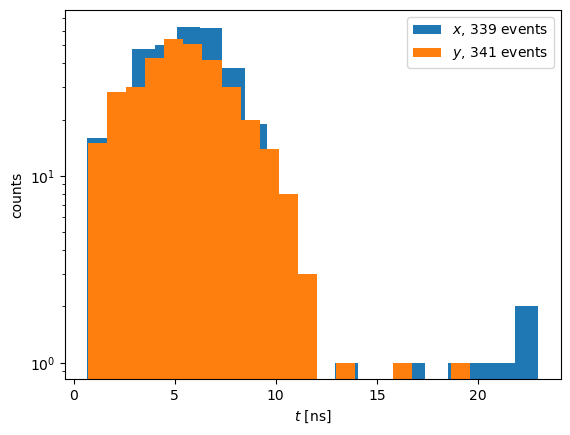

In [26]:
plt.hist(np.array(dts_x)*6.25, bins = 20, label = '$x$, {} events'.format(len(dts_x)))
plt.hist(np.array(dts_y)*6.25, bins = 20, label = '$y$, {} events'.format(len(dts_y)))
plt.yscale('log')
plt.xlabel('$t$ [ns]')
plt.ylabel('counts')
plt.legend()